# WiDS Datathon 2021

In [1]:
import os
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc

%matplotlib inline
pd.set_option("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None)

* https://www.kaggle.com/c/widsdatathon2021/data?select=TrainingWiDS2021.csv
* https://he.wikipedia.org/wiki/%D7%A1%D7%95%D7%9B%D7%A8%D7%AA
* https://www.health.gov.il/PublicationsFiles/diabetes_registry_report_2019.pdf

## Overview
This year's challenge will focus on models to determine whether a patient admitted to an ICU has been diagnosed with a particular type of diabetes, Diabetes Mellitus. Using data from the first 24 hours of intensive care, individuals and teams will explore labeled training data for model development. Participants will then upload predictions for unlabeled data to Kaggle and these predictions will be used to determine the public leaderboard rankings, as well as the final leaderboard revealed at the close of the competition.

Data analysis can be completed using your preferred tools. Tutorials, sample code, and other resources will be posted throughout the competition at widsconference.org/datathon-resources and on the Kaggle Discussion Forum.

The WiDS Datathon 2021 dataset is similar to the WiDS Datathon 2020 dataset, but prior experience is not needed. This year's WiDS Datathon will also feature a Phase 2 hosted by the National Science Foundation Big Data Innovation Hubs, to encourage research papers and further collaboration. Special thanks to Kaggle for supporting the suite of WiDS Datathon cash awards this year, totaling $10,000 USD

## Evaluation
Submissions for the leaderboard will be evaluated on the Area under the Receiver Operating Characteristic (ROC) curve between the predicted and the observed target (diabetes_mellitus_diagnosis).

Learn more about AUC in this developer crash course, this video, or this Kaggle Learn Forum post.

Submission Format
For each encounter_id in the test dataset, you are asked to explore the columns of data (for example, patient laboratory results, demographics, and vital signs) and create a model that classifies whether the ICU patient has been diagnosed with Diabetes Mellitus.

A diabetes_mellitus value of 1 corresponds to a positive diagnosis (i.e., the patient has been diagnosed to have Diabetes Mellitus) and a value of 0 corresponds to a negative diagnosis.

# EDA

In [2]:
# C:\\Users\\liran\\OneDrive\\שולחן העבודה\\classification&clustering\\csv_files
os.chdir('user path..')
os.getcwd()

'C:\\Users\\liran\\OneDrive\\שולחן העבודה\\classification&clustering\\csv_files'

In [3]:
df_train = pd.read_csv('TrainingWiDS2021.csv', index_col=0)
df_train.reset_index(drop=True, inplace=True)
df_test = pd.read_csv('UnlabeledWiDS2021.csv', index_col=0)
df_test.reset_index(drop=True, inplace=True)
df_dic = pd.read_csv('DataDictionaryWiDS2021.csv')
print(f'train shape: {df_train.shape}, test shape: {df_test.shape}, dic shape: {df_dic.shape}')

train shape: (130157, 180), test shape: (10234, 179), dic shape: (181, 6)


## tasks
* if the column of **bmi** is correct [weight (kg) / height (cm) / height (cm)] x 10,000
* see the diffrences in some parameters based on **ethnicity**, **age**
* cheking the influence of **hospitals_id** and **icu_id**
* checking the APACHE comorbidity influence on diabetes
* so the connection of **gcs_unable_apache** column to other **gcs** test
* look on **outliers**, watching and underline unusual indices tests
* maybe all the blood test yield to APACHE II & III diagnos, maybe doing clustering on **"APACHE covariate"** column
* fintuning of the null columns, threshold for null values

## get the numeric / categorial / binary columns

In [5]:
numeric_lst = []
categorial_lst = []
binary_lst = []
for index in range(len(df_dic['Category'])):
    if df_dic.loc[index, 'Data Type'] == 'numeric' or df_dic.loc[index, 'Data Type'] == 'integer':
        numeric_lst.append(df_dic.loc[index, 'Variable Name'])
    if df_dic.loc[index, 'Data Type'] == 'string':
        categorial_lst.append(df_dic.loc[index, 'Variable Name']) 
    if df_dic.loc[index,'Data Type'] == 'binary':
        binary_lst.append(df_dic.loc[index, 'Variable Name'])

remove_num_lst = ['encounter_id', 'hospital_id', 'icu_id', 'gcs_eyes_apache', 'gcs_motor_apache',
                 'gcs_verbal_apache']
for col in remove_num_lst:
    numeric_lst.remove(col)
    categorial_lst.append(col)

categorial_lst.remove('bmi')
numeric_lst.append('bmi')

## add data to the dictonary dataframe

In [6]:
df_dic['norma_val_low'] = None
df_dic['norma_val_high'] = None
df_dic['link'] = None

In [7]:
# complete the dic table
# BMI
df_dic.at[3, 'norma_val_low'] = 18.5
df_dic.at[3, 'norma_val_high'] = 30
df_dic.at[3, 'link'] = 'https://www.cdc.gov/healthyweight/assessing/bmi/adult_bmi/index.html'
# albumin
df_dic.loc[[17, 127, 128, 97, 98], 'norma_val_low'] = 35
df_dic.loc[[17, 127, 128, 97, 98], 'norma_val_high'] = 52
df_dic.loc[[17, 127, 128, 97, 98], 'link'] = 'https://www.clalit.co.il/he/medical/lab_tests/Pages/albumin.aspx'
# APACHE
df_dic.at[18, 'link'] = 'file:///C:/Users/liran/Downloads/ANZICS-APD-Data-Dictionary.pdf'
df_dic.at[19, 'link'] = 'file:///C:/Users/liran/Downloads/ANZICS-APD-Data-Dictionary.pdf'
# bilirubin
df_dic.loc[[22, 99, 100, 129, 130], 'norma_val_low'] = 1.71
df_dic.loc[[22, 99, 100, 129, 130], 'norma_val_high'] = 20.5
df_dic.loc[[22, 99, 100, 129, 130], 'link'] = 'https://www.mountsinai.org/health-library/tests/bilirubin-blood-test'
# blood urea nitrogen
df_dic.loc[[23, 101, 102, 131, 132], 'norma_val_low'] = 2.1
df_dic.loc[[23, 101, 102, 131, 132], 'norma_val_high'] = 7.1
df_dic.loc[[23, 101, 102, 131, 132], 'link'] = 'https://en.wikipedia.org/wiki/Blood_urea_nitrogen'
# creatinine
df_dic.loc[[24, 105, 106, 135, 136], 'norma_val_low'] = 61.9
df_dic.loc[[24, 105, 106, 135, 136], 'norma_val_high'] = 114.9
df_dic.loc[[24, 105, 106, 135, 136], 'link'] = 'https://www.mountsinai.org/health-library/tests/creatinine-blood-test'
# fio2
df_dic.at[25, 'norma_val_low'] = 0
df_dic.at[25, 'norma_val_high'] = 0.5
df_dic.at[25, 'link'] = 'https://en.wikipedia.org/wiki/Fraction_of_inspired_oxygen'
# gcs eyes
df_dic.at[26, 'norma_val_low'] = 1 # death
df_dic.at[26, 'norma_val_high'] = 4 # regular
df_dic.at[26, 'link'] = 'https://www.sciencedirect.com/topics/neuroscience/glasgow-coma-scale'
# gcs motoer
df_dic.at[27, 'norma_val_low'] = 1 # death
df_dic.at[27, 'norma_val_high'] = 6 # regular
df_dic.at[27, 'link'] = 'https://www.sciencedirect.com/topics/neuroscience/glasgow-coma-scale'
# gcs verbal
df_dic.at[29, 'norma_val_low'] = 1 # death
df_dic.at[29, 'norma_val_high'] = 5 # regular
df_dic.at[29, 'link'] = 'https://www.sciencedirect.com/topics/neuroscience/glasgow-coma-scale'
# glucose, there is a mistake the units are mg/dL and not mmol/L
df_dic.loc[[30, 107, 108, 137, 138], 'norma_val_low'] = 0 
df_dic.loc[[30, 107, 108, 137, 138], 'norma_val_high'] = 140 
df_dic.loc[[30, 107, 108, 137, 138], 'link'] = 'https://www.google.com/search?q=glucose+mmol%2Fl+normal+range&oq=glucose+mm&aqs=chrome.0.69i59j69i57j0i512l7.3538j0j4&sourceid=chrome&ie=UTF-8'
df_dic.loc[[30, 107, 108, 137, 138], 'Unit of Measure'] = 'mg/dL'
# hematocrit % red  blood cells
for index in [32, 113, 114, 143, 144]:
    df_dic.at[index, 'norma_val_low'] = (0.383, 0.355) # (men, women)
    df_dic.at[index, 'norma_val_high'] = (0.486, 0.449) # (men, women)
    df_dic.at[index, 'link'] = 'https://www.mayoclinic.org/tests-procedures/hematocrit/about/pac-20384728'
# arterial pressure
df_dic.at[34, 'norma_val_low'] = 70
df_dic.at[34, 'norma_val_high'] = 100
df_dic.at[34, 'link'] = 'https://www.healthline.com/health/mean-arterial-pressure#normal-map'
# partial pressure of carbon dioxide (oxygenation)
df_dic.at[35, 'norma_val_low'] = 38
df_dic.at[35, 'norma_val_high'] = 42
df_dic.at[35, 'link'] = 'https://medlineplus.gov/ency/article/003855.htm'
# partial pressure of carbon dioxide (acid-base)
df_dic.loc[[36, 157, 158, 165, 166], 'norma_val_low'] = 35
df_dic.loc[[36, 157, 158, 165, 166], 'norma_val_high'] = 45
df_dic.loc[[36, 157, 158, 165, 166], 'link'] = 'https://www.google.com/search?q=partial+pressure+carbon+dioxide+acid-base+normal+range&sxsrf=APq-WBujQzVai8PZ4izdZJIhjbhlnc5ibw%3A1646318801563&ei=0dQgYsH7Ic367_UPnrq0uAw&ved=0ahUKEwiBqOq6l6r2AhVN_bsIHR4dDccQ4dUDCA4&uact=5&oq=partial+pressure+carbon+dioxide+acid-base+normal+range&gs_lcp=Cgdnd3Mtd2l6EAMyBQgAEKIEOgcIABBHELADOgQIIRAKSgQIQRgASgQIRhgAUPABWOkGYK8JaAJwAXgAgAGMAYgBhwKSAQMwLjKYAQCgAQKgAQHIAQjAAQE&sclient=gws-wiz'
# pao2 pressure
df_dic.at[37, 'norma_val_low'] = 75
df_dic.at[37, 'norma_val_high'] = 100
df_dic.at[37, 'link'] = 'https://medlineplus.gov/ency/article/003855.htm'
# pH
df_dic.loc[[38, 159, 160, 167, 168], 'norma_val_low'] = 7.35
df_dic.loc[[38, 159, 160, 167, 168], 'norma_val_high'] = 7.45
df_dic.loc[[38, 159, 160, 167, 168], 'link'] = 'https://www.msdmanuals.com/home/hormonal-and-metabolic-disorders/acid-base-balance/overview-of-acid-base-balance'
# respiratory (Breaths per minute)
df_dic.loc[[39, 59, 60, 85, 86], ['norma_val_low']] = 12
df_dic.loc[[39, 59, 60, 85, 86], ['norma_val_high']] = 16
df_dic.loc[[39, 59, 60, 85, 86], ['link']] = 'https://www.hopkinsmedicine.org/health/conditions-and-diseases/vital-signs-body-temperature-pulse-rate-respiration-rate-blood-pressure'
# sodium 
df_dic.loc[[40, 123, 124, 153, 154], 'norma_val_low'] = 136
df_dic.loc[[40, 123, 124, 153, 154], 'norma_val_high'] = 145
df_dic.loc[[40, 123, 124, 153, 154], 'link'] = 'https://www.google.com/search?q=sodium+mmol%2Fliter&oq=sodium+mmol%2Fliter&aqs=chrome..69i57j0i22i30l9.7734j0j4&sourceid=chrome&ie=UTF-8'
# body temp (C deg) 
df_dic.loc[[41, 69, 70, 95, 96], ['norma_val_low']] = 36.1
df_dic.loc[[41, 69, 70, 95, 96], ['norma_val_high']] = 37.2
df_dic.loc[[41, 69, 70, 95, 96], ['link']] = 'https://www.google.com/search?q=temperature+normal+range+celsius&oq=temperature+normal+range+ce&aqs=chrome.1.69i57j0i19j0i10i19i22i30j0i19i22i30l7.6329j0j9&sourceid=chrome&ie=UTF-8'
# urine 
df_dic.at[42, 'norma_val_low'] = 800
df_dic.at[42, 'norma_val_high'] = 2000
df_dic.at[42, 'link'] = 'https://www.google.com/search?q=urine+normal+range&oq=urine+normal&aqs=chrome.2.69i57j0i512l3j0i22i30l6.5853j0j9&sourceid=chrome&ie=UTF-8'
# wbc 
df_dic.loc[[44, 125, 126, 155, 156], 'norma_val_low'] = 4.5
df_dic.loc[[44, 125, 126, 155, 156], 'norma_val_high'] = 11
df_dic.loc[[44, 125, 126, 155, 156], 'link'] = 'https://www.google.com/search?q=wbc+normal+range&oq=wbc+normal&aqs=chrome.0.0i512j69i57j0i512l8.3470j0j9&sourceid=chrome&ie=UTF-8'
# diastolic blood pressure max
df_dic.loc[[45, 47, 49, 53, 55, 57, 71, 73, 75, 79, 81, 83], ['norma_val_low']] = 90
df_dic.loc[[45, 47, 49, 53, 55, 57, 71, 73, 75, 79, 81, 83], ['norma_val_high']] = 120
df_dic.loc[[45, 47, 49, 53, 55, 57, 71, 73, 75, 79, 81, 83], ['link']] = 'https://www.google.com/search?q=Millimetres+of+mercury+diastolic+blood+pressure+high+range&sxsrf=APq-WBsQrGoxjvanoyrLejEDEPIY2DNOhQ%3A1646319802334&ei=utggYuPjE_P-7_UPkouMgAk&ved=0ahUKEwjjqISYm6r2AhVz_7sIHZIFA5AQ4dUDCA4&uact=5&oq=Millimetres+of+mercury+diastolic+blood+pressure+high+range&gs_lcp=Cgdnd3Mtd2l6EAM6BwgAEEcQsAM6BggjECcQE0oECEEYAEoECEYYAFC0D1iqF2DuHGgDcAF4AIABjgGIAY4CkgEDMC4ymAEAoAEBoAECyAEIwAEB&sclient=gws-wiz'
# diastolic blood pressure min
df_dic.loc[[46, 48, 50, 54, 56, 58, 72, 74, 76, 80, 82, 84], ['norma_val_low']] = 60
df_dic.loc[[46, 48, 50, 54, 56, 58, 72, 74, 76, 80, 82, 84], ['norma_val_high']] = 80
df_dic.loc[[46, 48, 50, 54, 56, 58, 72, 74, 76, 80, 82, 84], ['link']] = 'https://www.google.com/search?q=Millimetres+of+mercury+diastolic+blood+pressure+high+range&sxsrf=APq-WBsQrGoxjvanoyrLejEDEPIY2DNOhQ%3A1646319802334&ei=utggYuPjE_P-7_UPkouMgAk&ved=0ahUKEwjjqISYm6r2AhVz_7sIHZIFA5AQ4dUDCA4&uact=5&oq=Millimetres+of+mercury+diastolic+blood+pressure+high+range&gs_lcp=Cgdnd3Mtd2l6EAM6BwgAEEcQsAM6BggjECcQE0oECEEYAEoECEYYAFC0D1iqF2DuHGgDcAF4AIABjgGIAY4CkgEDMC4ymAEAoAEBoAECyAEIwAEB&sclient=gws-wiz'
# heart beats, 58
df_dic.loc[[31, 51, 52, 77, 78], ['norma_val_low']] = 60
df_dic.loc[[31, 51, 52, 77, 78], ['norma_val_high']] = 100
df_dic.loc[[31, 51, 52, 77, 78], ['link']] = 'https://www.mayoclinic.org/healthy-lifestyle/fitness/expert-answers/heart-rate/faq-20057979'
# peripheral oxygen saturation
df_dic.loc[[61, 62, 87, 88], ['norma_val_low']] = 80
df_dic.loc[[61, 62, 87, 88], ['norma_val_high']] = 100
df_dic.loc[[61, 62, 87, 88], ['link']] = 'https://www.google.com/search?q=peripheral+oxygen+saturation+normal+range&oq=peripheral+oxygen+saturation+nor&aqs=chrome.0.0i19j69i57.4484j0j9&sourceid=chrome&ie=UTF-8'
# peripheral oxygen saturation
df_dic.loc[list(range(63,69)) + list(range(89,95)), ['norma_val_low']] = 90
df_dic.loc[list(range(63,69)) + list(range(89,95)), ['norma_val_high']] = 120
df_dic.loc[list(range(63,69)) + list(range(89,95)), ['link']] = 'https://www.google.com/search?q=systolic+blood+pressure+normal+range&oq=systolic+blood+pressure+normal+&aqs=chrome.1.69i57j0i512j0i22i30l8.3578j0j9&sourceid=chrome&ie=UTF-8'
# calcium
df_dic.loc[[103, 104, 133, 134], ['norma_val_low']] = 2.2
df_dic.loc[[103, 104, 133, 134], ['norma_val_high']] = 2.7
df_dic.loc[[103, 104, 133, 134], ['link']] = 'https://www.google.com/search?q=calcium+mmol%2Fl+normal+range&sxsrf=APq-WBsG2bhUTZY8lmNUtZa_BoAHAIpqcQ%3A1646389996785&ei=7OohYqOrL8bWgQaipY2AAQ&oq=calcium+mmol%2FL%09+normal+range&gs_lcp=Cgdnd3Mtd2l6EAMYADIFCAAQywEyBggAEAUQHjIGCAAQCBAeMgYIABAIEB4yBggAEAgQHjIGCAAQCBAeMgYIABAIEB4yBggAEAgQHjIGCAAQCBAeMgYIABAIEB46BAgjECc6BggAEAcQHkoECEEYAEoECEYYAFDeB1i4GWCBKWgBcAF4AIABgwGIAYMCkgEDMC4ymAEAoAEBoAECwAEB&sclient=gws-wiz'
# calcium
df_dic.loc[[109, 110, 139, 140], ['norma_val_low']] = 23
df_dic.loc[[109, 110, 139, 140], ['norma_val_high']] = 30
df_dic.loc[[109, 110, 139, 140], ['link']] = 'https://www.urmc.rochester.edu/encyclopedia/content.aspx?contenttypeid=167&contentid=bicarbonate'
# hemaglobin
df_dic.loc[[111, 112, 141, 142], ['norma_val_low']] = 13.2
df_dic.loc[[111, 112, 141, 142], ['norma_val_high']] = 16.6
df_dic.loc[[111, 112, 141, 142], ['link']] = 'https://www.google.com/search?q=hemoglobin+normal+range&oq=hemoglobin+no&aqs=chrome.0.0i512j69i57j0i512l8.5174j0j4&sourceid=chrome&ie=UTF-8'
# inr
df_dic.loc[[115, 116, 145, 146], ['norma_val_low']] = 0
df_dic.loc[[115, 116, 145, 146], ['norma_val_high']] = 1.1
df_dic.loc[[115, 116, 145, 146], ['link']] = 'https://www.google.com/search?q=international+normalized+ratio+normal+range&oq=international+normalized+ratio+nor&aqs=chrome.1.69i57j0i512j0i22i30l8.2788j0j9&sourceid=chrome&ie=UTF-8'
# lactate
df_dic.loc[[117, 118, 147, 148], ['norma_val_low']] = 0.5
df_dic.loc[[117, 118, 147, 148], ['norma_val_high']] = 1
df_dic.loc[[117, 118, 147, 148], ['link']] = 'https://www.google.com/search?q=lactate+concentration+normal+range%5C&oq=lactate+concentration+normal+range%5C&aqs=chrome..69i57j33i22i29i30l9.4880j0j9&sourceid=chrome&ie=UTF-8'
# platelets
df_dic.loc[[119, 120, 149, 150], ['norma_val_low']] = 150
df_dic.loc[[119, 120, 149, 150], ['norma_val_high']] = 400
df_dic.loc[[119, 120, 149, 150], ['link']] = 'https://www.google.com/search?q=platelets+normal+range+10%5E9%2Fl&sxsrf=APq-WBv1bOsJhV_LzBa5PBpLGBb3WHROcA%3A1646391636686&ei=VPEhYvDHKcLukgXBh4zwBg&ved=0ahUKEwjwwanlpqz2AhVCt6QKHcEDA24Q4dUDCA4&uact=5&oq=platelets+normal+range+10%5E9%2Fl&gs_lcp=Cgdnd3Mtd2l6EAMyCAghEBYQHRAeOgUIABCABDoGCAAQFhAeSgQIQRgASgQIRhgAUMQCWIgcYPcdaAFwAXgAgAGZAYgBwweSAQMwLjeYAQCgAQHAAQE&sclient=gws-wiz'
# potassium
df_dic.loc[[121, 122, 151, 152], ['norma_val_low']] = 3.6
df_dic.loc[[121, 122, 151, 152], ['norma_val_high']] = 5.2
df_dic.loc[[121, 122, 151, 152], ['link']] = 'https://www.google.com/search?q=potassium+normal+range&oq=potassium+normal&aqs=chrome.0.0i512j69i57j0i512l8.3468j0j9&sourceid=chrome&ie=UTF-8'
# potassium
df_dic.loc[[161, 162, 169, 170], ['norma_val_low']] = 75
df_dic.loc[[161, 162, 169, 170], ['norma_val_high']] = 100
df_dic.loc[[161, 162, 169, 170], ['link']] = 'https://www.google.com/search?q=arterial+partial+pressure+of+oxygen+normal+range&oq=arterial+partial+pressure+of+oxygen+normal+range&aqs=chrome..69i57.5892j0j9&sourceid=chrome&ie=UTF-8'

In [8]:
def fun(path):
    if path != None and not(path.startswith('file')):
        f_url = os.path.basename(path) 
        return f'<a href="{path}">{f_url}</a>'
    else:
        return path

In [9]:
df_dic_style = df_dic.style.format({'link' : fun})

In [10]:
df_dic_style

,Category,Variable Name,Unit of Measure,Data Type,Description,Example,norma_val_low,norma_val_high,link
0,identifier,encounter_id,None,integer,Unique identifier associated with a patient unit stay,None,None,None,None
1,identifier,hospital_id,None,integer,Unique identifier associated with a hospital,None,None,None,None
2,demographic,age,Years,numeric,The age of the patient on unit admission,None,None,None,None
3,demographic,bmi,kilograms/metres^2,string,The body mass index of the person on unit admission,21.5,18.500000,30,index.html
4,demographic,elective_surgery,None,binary,Whether the patient was admitted to the hospital for an elective surgical operation,0,None,None,None
5,demographic,ethnicity,None,string,The common national or cultural tradition which the person belongs to,Caucasian,None,None,None
6,demographic,gender,None,string,The genotypical sex of the patient,F,None,None,None
7,demographic,height,centimetres,numeric,The height of the person on unit admission,180,None,None,None
8,demographic,hospital_admit_source,None,string,The location of the patient prior to being admitted to the hospital,Home,None,None,None
9,demographic,icu_admit_source,None,string,The location of the patient prior to being admitted to the unit,Operating room,None,None,None


## imbalanced data

In [11]:
df_train['diabetes_mellitus'].value_counts(normalize=True)

0    0.783715
1    0.216285
Name: diabetes_mellitus, dtype: float64

## duplication

In [12]:
print(f'Num of duplicatiions in train df: {sum(df_train.duplicated())}\
\nNum of duplicatiions in test df: {sum(df_test.duplicated())}')

Num of duplicatiions in train df: 0
Num of duplicatiions in test df: 0


## looking on nall values

In [13]:
threshold = 0.2
print(sum(df_train.isnull().sum() / len(df_train) <= threshold)) # num of columns we stay with based on threshold 
print(sum(df_test.isnull().sum() / len(df_train) <= threshold)) # num of columns we stay with based on threshold 

101
179


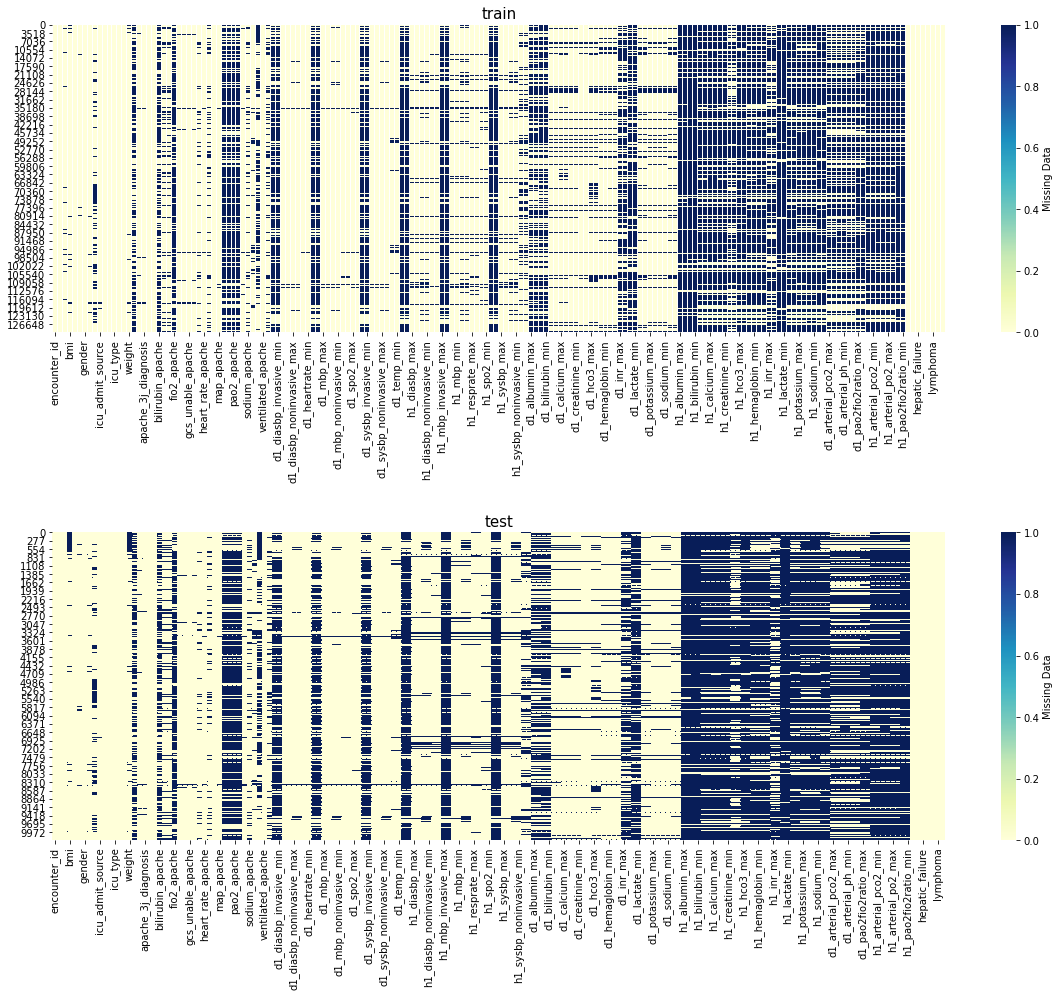

In [14]:
fig, axs = plt.subplots(2, figsize=(20,15))
sns.heatmap(df_train.isnull(), cmap="YlGnBu", cbar_kws={'label': 'Missing Data'}, ax=axs[0])
sns.heatmap(df_test.isnull(), cmap="YlGnBu", cbar_kws={'label': 'Missing Data'}, ax=axs[1])
axs[0].set_title('train', size=15)
axs[1].set_title('test', size=15)
plt.subplots_adjust(hspace=0.65)

In [15]:
# from matplotlib import rcParams
# rcParams['figure.figsize'] = 20,8

# sns.displot(
#     data=df_train.isna().melt(value_name="missing"),
#     y="variable",
#     hue="missing",
#     multiple="fill",
#     aspect=1.25)

<AxesSubplot:>

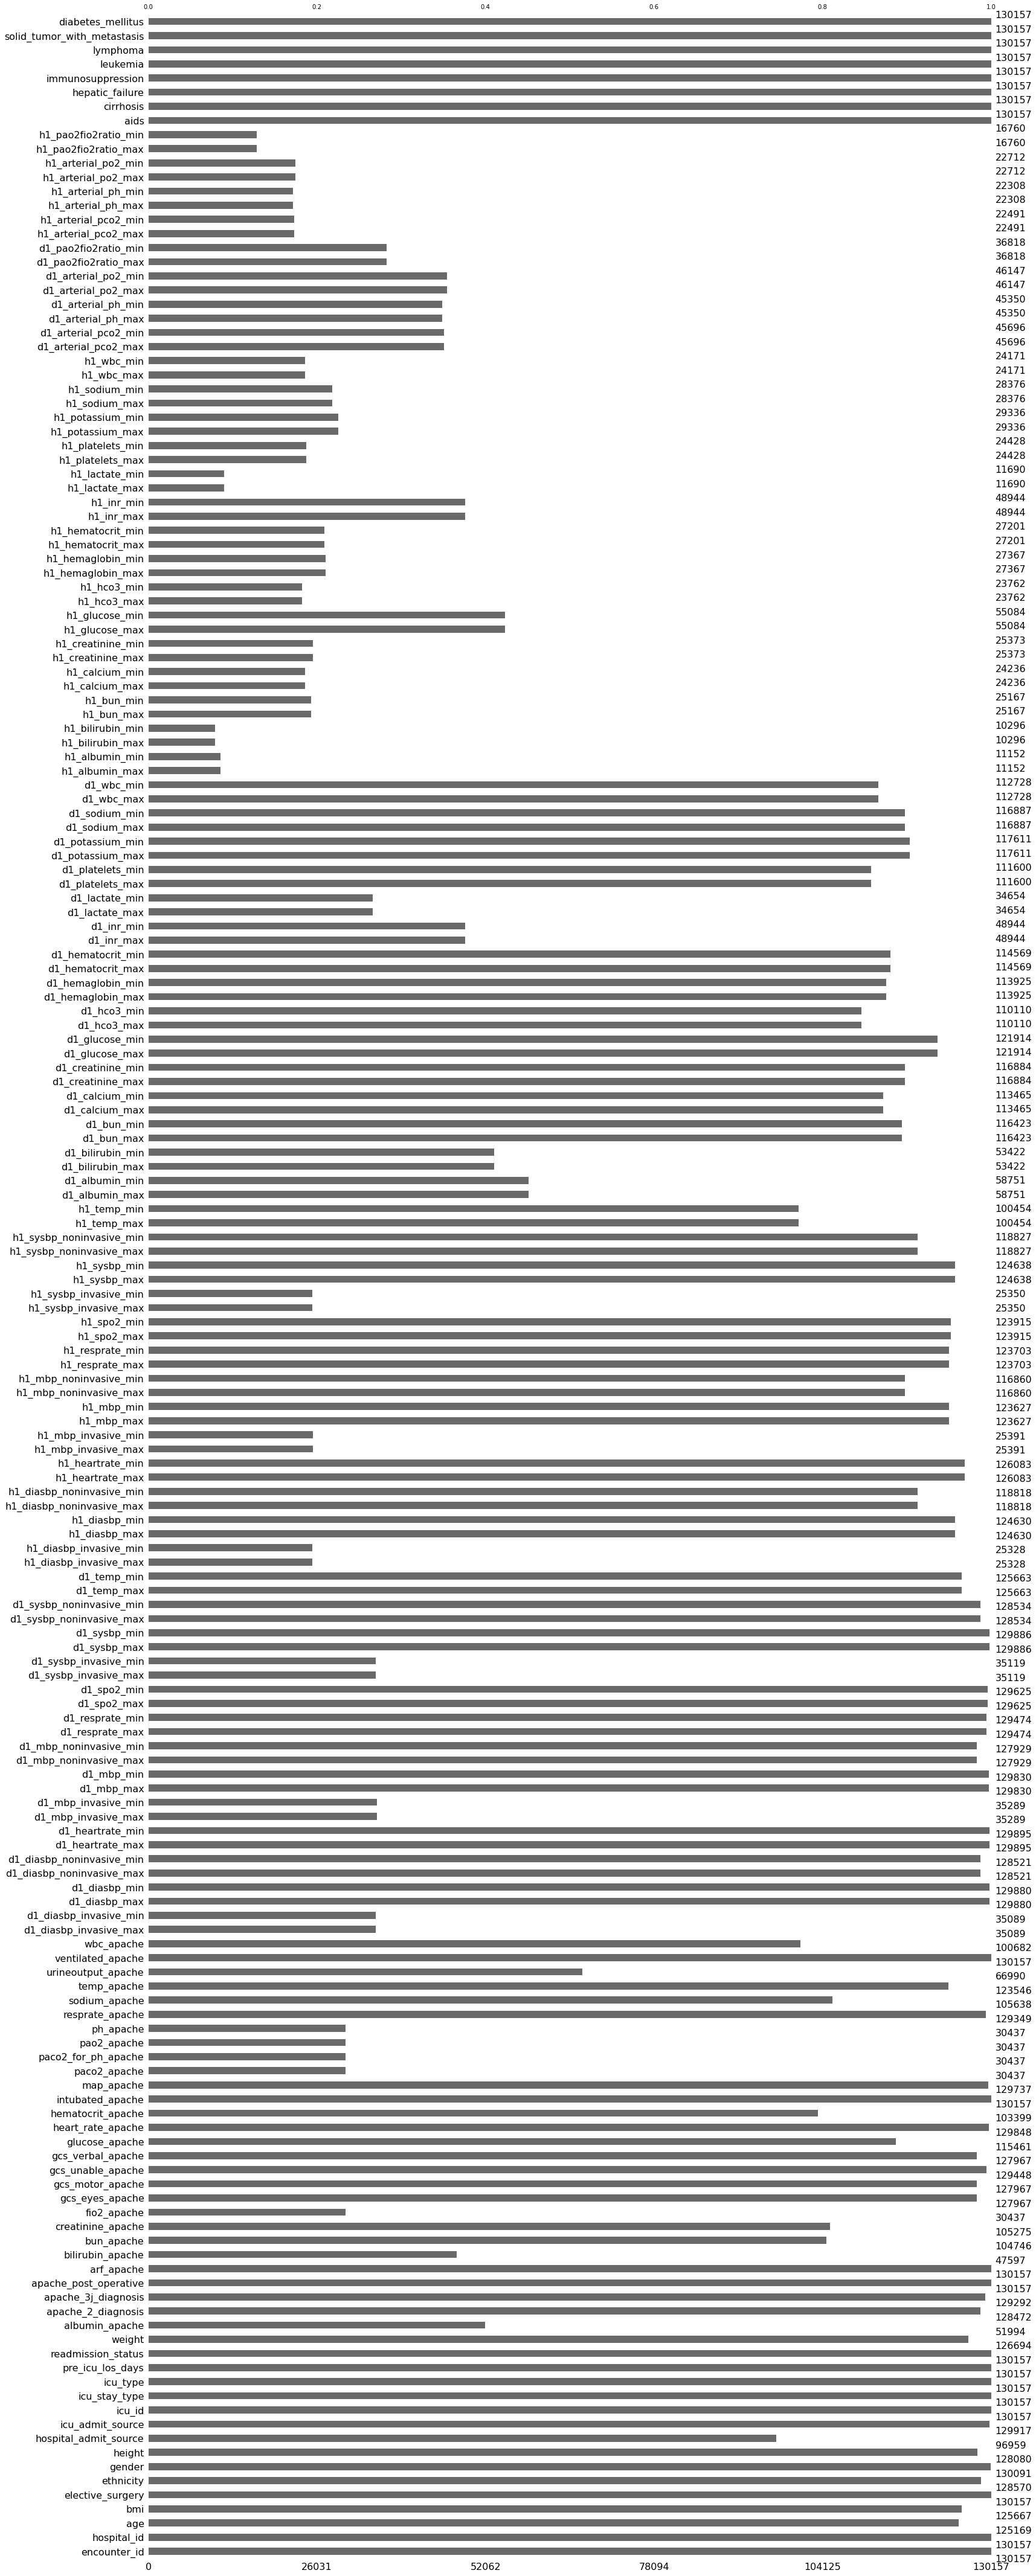

In [16]:
msno.bar(df_train)

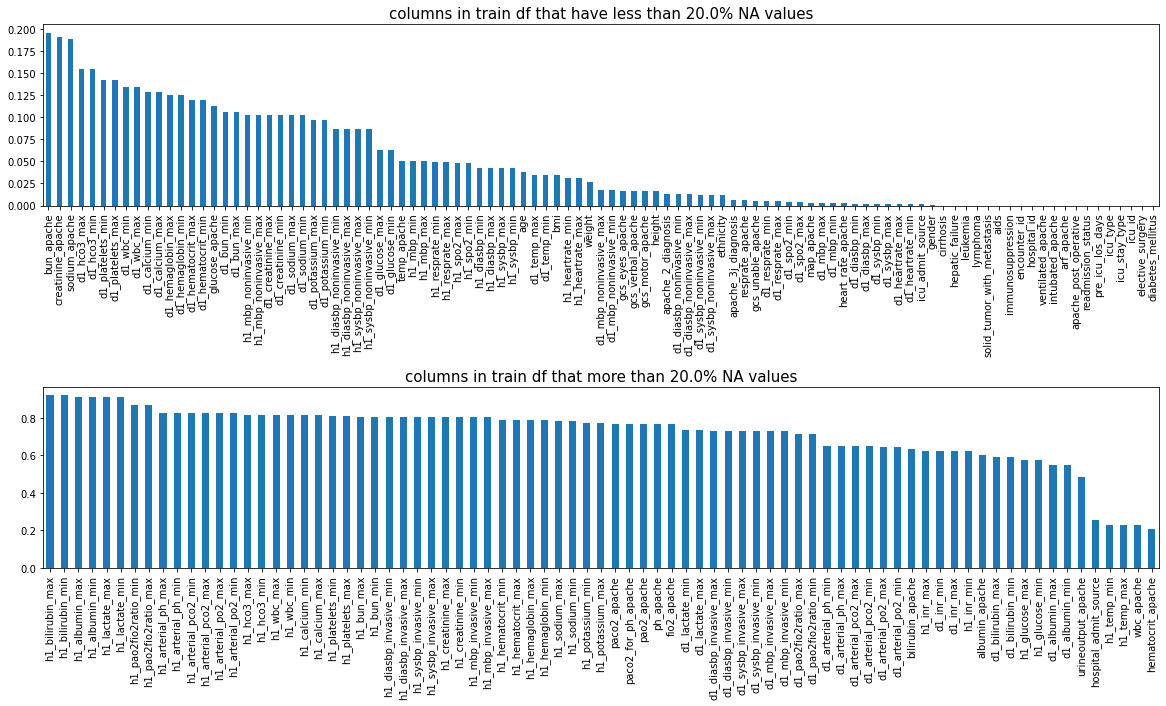

In [17]:
fig, axs = plt.subplots(2)
mask = df_train.isna().sum().sort_values(ascending=False) / len(df_train) <= threshold
(df_train.isna().sum().sort_values(ascending=False) / len(df_train))[mask].plot(kind='bar', ax=axs[0], figsize=(20,10))
(df_train.isna().sum().sort_values(ascending=False) / len(df_train))[~mask].plot(kind='bar', ax=axs[1], figsize=(20,10))
axs[0].set_title(f'columns in train df that have less than {threshold*100}% NA values', size=15)
axs[1].set_title(f'columns in train df that more than {threshold*100}% NA values', size=15)
plt.subplots_adjust(hspace=1)

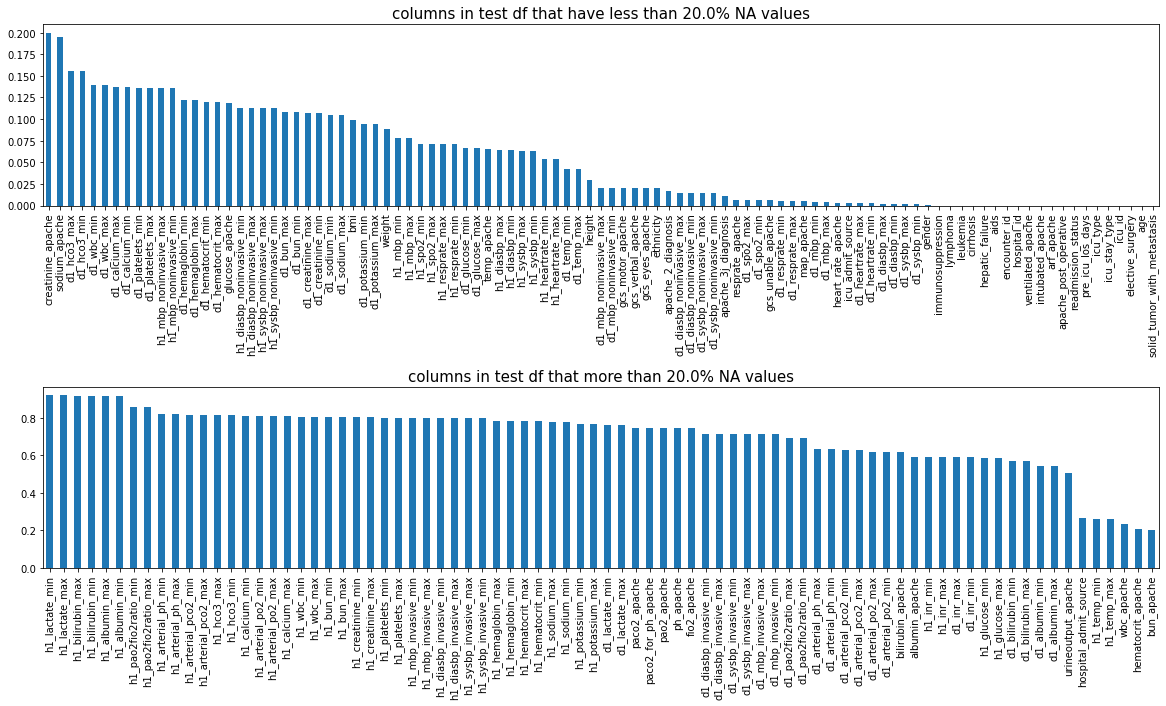

In [18]:
fig, axs = plt.subplots(2)
threshold = 0.2
mask = df_test.isna().sum().sort_values(ascending=False) / len(df_test) <= threshold
(df_test.isna().sum().sort_values(ascending=False) / len(df_test))[mask].plot(kind='bar', ax=axs[0], figsize=(20,10))
(df_test.isna().sum().sort_values(ascending=False) / len(df_test))[~mask].plot(kind='bar', ax=axs[1], figsize=(20,10))
axs[0].set_title(f'columns in test df that have less than {threshold*100}% NA values', size=15)
axs[1].set_title(f'columns in test df that more than {threshold*100}% NA values', size=15)
plt.subplots_adjust(hspace=1)

In [ ]:
# exam this plot after features engineering
# msno.heatmap(df_train[['encounter_id', 'hospital_id', 'age', 'bmi', 'elective_surgery',
#        'ethnicity', 'gender', 'height', 'hospital_admit_source',
#        'icu_admit_source']])

### drop null columns based on threshold

In [19]:
# columns to be drop
col_to_be_drop = (df_train.isnull().sum() / df_train.shape[0] <= threshold) \
[~(df_train.isnull().sum() / df_train.shape[0] <= threshold)].index
print(f'number of columns to drop: {len(col_to_be_drop)}')

number of columns to drop: 79


In [20]:
df_train.drop(columns=col_to_be_drop, inplace=True)
df_test.drop(columns=col_to_be_drop, inplace=True)

In [21]:
print(f'train shape: {df_train.shape}, test shape: {df_test.shape}')

train shape: (130157, 101), test shape: (10234, 100)


In [22]:
df_train.isnull().sum().sort_values()

encounter_id                       0
lymphoma                           0
leukemia                           0
immunosuppression                  0
hepatic_failure                    0
cirrhosis                          0
aids                               0
solid_tumor_with_metastasis        0
ventilated_apache                  0
intubated_apache                   0
arf_apache                         0
apache_post_operative              0
readmission_status                 0
diabetes_mellitus                  0
icu_type                           0
icu_stay_type                      0
hospital_id                        0
elective_surgery                   0
pre_icu_los_days                   0
icu_id                             0
gender                            66
icu_admit_source                 240
d1_heartrate_max                 262
d1_heartrate_min                 262
d1_sysbp_min                     271
d1_sysbp_max                     271
d1_diasbp_min                    277
d

## age

In [23]:
df_train['age'].isnull().sum()

4988

In [24]:
# what we do with 0.0 age
df_train['age'].value_counts().sort_index().head(5)

0.0      30
16.0     85
17.0    180
18.0    377
19.0    490
Name: age, dtype: int64

In [25]:
g = df_train.groupby(['age', 'gender','diabetes_mellitus']).agg(gender_count=pd.NamedAgg(column="diabetes_mellitus", aggfunc="size"))
g

gender_count
age  gender diabetes_mellitus              
0.0  F      0                             1
            1                             1
     M      0                             2
16.0 F      0                            43
            1                             4
     M      0                            35
            1                             3
17.0 F      0                            77
            1                            11
     M      0                            85
            1                             7
18.0 F      0                           143
            1                            24
     M      0                           181
            1                            29
19.0 F      0                           205
            1                            30
     M      0                           231
            1                            23
20.0 F      0                           195
            1                            34
     M      0                           226
            1                            18
21.0 F      0                           203
            1                            39
     M      0                           262
            1                            40
22.0 F      0                           215
            1                            30
     M      0                           289
            1                            24
23.0 F      0                           249
            1                            27
     M      0                           244
            1                            36
24.0 F      0                           248
            1                            47
     M      0                           272
            1                            22
25.0 F      0                           263
            1                            33
     M      0                           299
            1                            26
26.0 F      0                           278
            1                            23
     M      0                           304
            1                            33
27.0 F      0                           237
            1                            47
     M      0                           297
            1                            26
28.0 F      0                           246
            1                            43
     M      0                           319
            1                            35
29.0 F      0                           266
            1                            42
     M      0                           266
            1                            22
30.0 F      0                           267
            1                            50
     M      0                           343
            1                            36
31.0 F      0                           265
            1                            40
     M      0                           318
            1                            37
32.0 F      0                           291
            1                            27
     M      0                           316
            1                            50
33.0 F      0                           310
            1                            37
     M      0                           321
            1                            45
34.0 F      0                           299
            1                            47
     M      0                           383
            1                            46
35.0 F      0                           304
            1                            48
     M      0                           368
            1                            47
36.0 F      0                           348
            1                            49
     M      0                           380
            1                            58
37.0 F      0                           299
            1                            48
     M      0              

<AxesSubplot:title={'center':'pct of male and female vs age'}, xlabel='age', ylabel='pct %'>

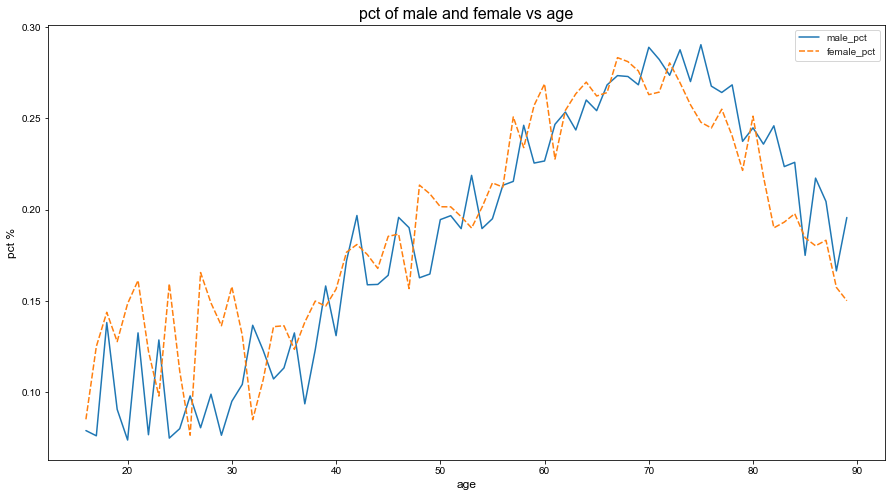

In [26]:
# ploting the age influence on diabetes hue by gender
m = df_train.groupby(['age']).apply(lambda x: x[(x['gender'] == 'M')]['diabetes_mellitus'].sum()
                                    / len(x[(x['gender'] == 'M')]['diabetes_mellitus']))
m.name = 'male_pct'

f = df_train.groupby(['age']).apply(lambda x: x[(x['gender'] == 'F')]['diabetes_mellitus'].sum()
                                    / len(x[(x['gender'] == 'F')]['diabetes_mellitus']))
f.name = 'female_pct'

df_gender_pct = pd.concat([m, f], axis=1)

fig, ax = plt.subplots()
fig.set_size_inches(15,8)
ax.set_title('pct of male and female vs age', fontsize=16)
ax.set_xlabel('age', fontsize=12)
ax.set_ylabel('pct %', fontsize=12)
sns.set_style("whitegrid")
sns.lineplot(data=df_gender_pct.loc[1:,])

<AxesSubplot:xlabel='age'>

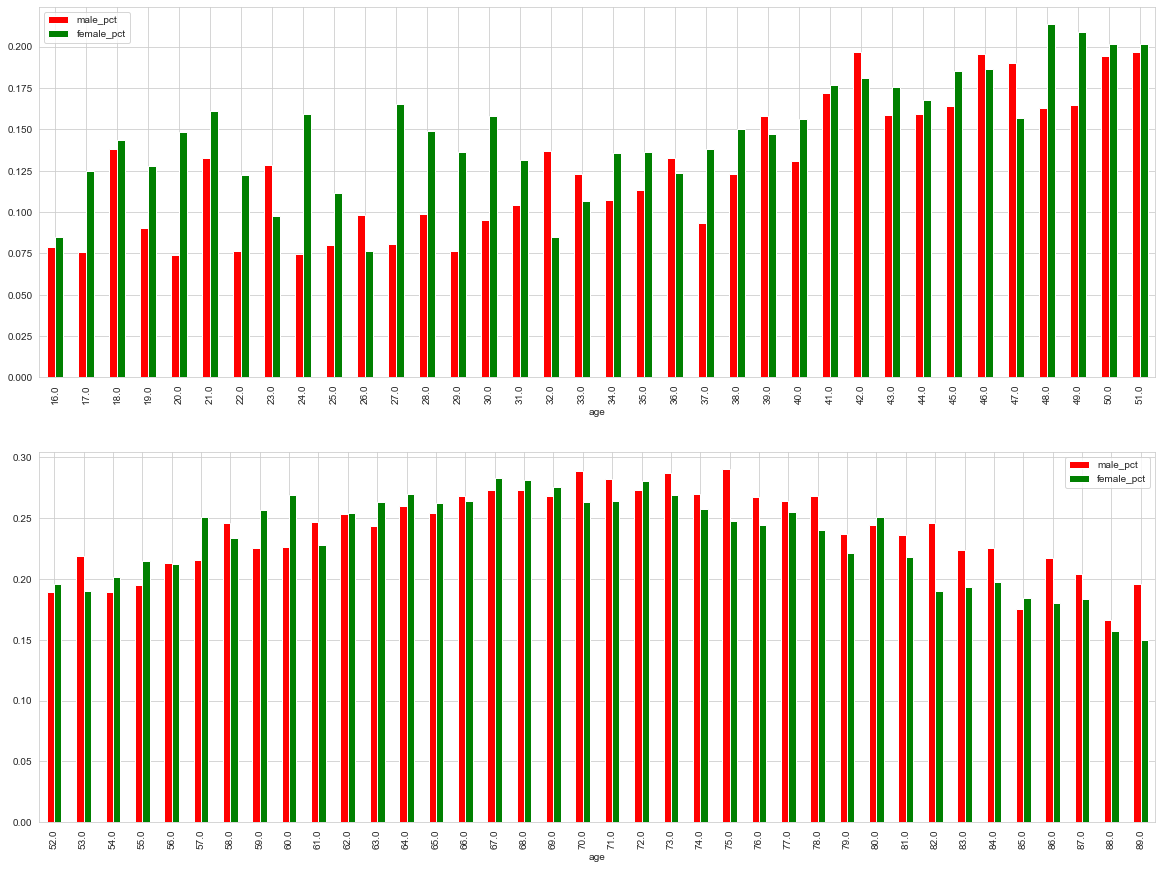

In [27]:
# another vizualization
df_gender_pct.reset_index(inplace=True)
half = int(len(df_gender_pct)/2)
fig, axs = plt.subplots(2)
df_gender_pct[1:half].plot.bar(x='age',y=['male_pct', 'female_pct'], color={"male_pct": "red", "female_pct": "green"}, ax=axs[0], figsize=(20,15))
df_gender_pct[half:].plot.bar(x='age',y=['male_pct', 'female_pct'], color={"male_pct": "red", "female_pct": "green"}, ax=axs[1], figsize=(20,15))

## ethnicity

In [28]:
sum(df_train.ethnicity.isnull())

1587

In [29]:
ethnicity_s = df_train.ethnicity.value_counts()
ethnicity_s

Caucasian           100236
African American     13911
Other/Unknown         6261
Hispanic              5049
Asian                 2198
Native American        915
Name: ethnicity, dtype: int64

In [32]:
g = df_train.groupby(['ethnicity']).agg(pct_diabetes=pd.NamedAgg(column="diabetes_mellitus", aggfunc=lambda x: 100*(x.sum() / len(x))),
                                         num_of_patients=pd.NamedAgg(column="diabetes_mellitus", aggfunc=lambda x: len(x)))
g.sort_values(by='pct_diabetes', ascending=False, inplace=True)
g

,pct_diabetes,num_of_patients
ethnicity,,
Native American,32.131148,915
African American,26.266983,13911
Other/Unknown,25.475164,6261
Hispanic,24.618736,5049
Asian,24.476797,2198
Caucasian,20.556487,100236


Text(0, 0.5, 'Number of People Suffering from Diabetes')

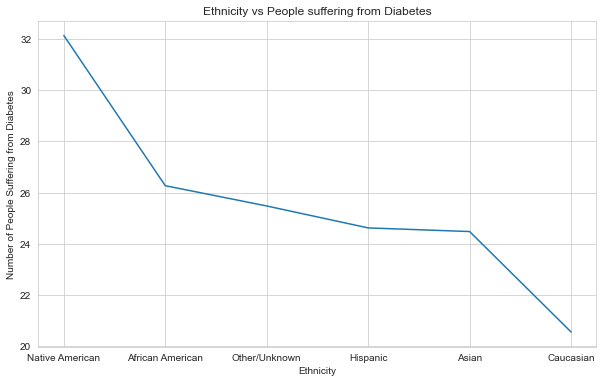

In [31]:
plt.figure(figsize=(10,6))
plt.title("Ethnicity vs People suffering from Diabetes")
sns.lineplot(x=g.index,y=g["pct_diabetes"])
plt.xlabel("Ethnicity")
plt.ylabel("Number of People Suffering from Diabetes")

In [33]:
g = df_train.groupby(['ethnicity', 'gender']).apply(lambda x: x['diabetes_mellitus'].sum() / len(x['diabetes_mellitus'])).unstack()
g['diff'] = 100 * abs(g['F'] - g['M'])
g.sort_values(by='diff', ascending=False)

gender,F,M,diff
ethnicity,,,
African American,0.287239,0.239698,4.754049
Asian,0.228053,0.260000,3.194656
Hispanic,0.237708,0.253599,1.589069
Caucasian,0.198517,0.211470,1.295385
Other/Unknown,0.262158,0.249931,1.222717
Native American,0.315556,0.326882,1.132616


## bmi, weight, height

In [34]:
df_train[['bmi', 'weight', 'height']].isnull().sum()

bmi       4490
weight    3463
height    2077
dtype: int64

In [35]:
df_train['bmi'] = round(10000 * df_train['weight'] / (df_train['height'] ** 2), 8)
mask_lst= []
for i in range(len(df_train)):
    mask_lst.append(round(10000*df_train.weight[i] / (df_train.height[i]**2), str(df_train.bmi[i])[::-1].find('.')) == df_train.bmi[i])
    
sum(mask_lst)

125667

Text(30.5, 6659.415000000001, 'Num of obes: 46276')

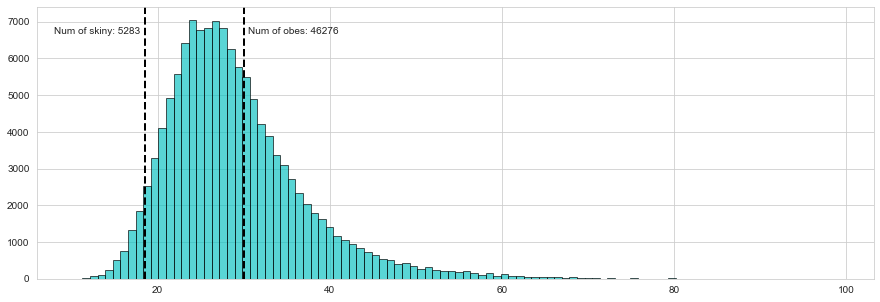

In [36]:
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.hist(df_train.bmi, bins=100, color='c', edgecolor='k', alpha=0.65)
plt.axvline(18.5, color='k', linestyle='dashed', linewidth=2)
plt.axvline(30, color='k', linestyle='dashed', linewidth=2)
obes = len(df_train[df_train['bmi']>=30])
skiny = len(df_train[df_train['bmi']<=18.5])
min_ylim, max_ylim = plt.ylim()
plt.text(8, max_ylim*0.9, f'Num of skiny: {skiny}')
plt.text(30.5, max_ylim*0.9, f'Num of obes: {obes:}')

In [37]:
def bmi_infl(val_lst, col_name, col):
    bmi_df[col_name] = None
    bmi_df.loc[bmi_df[col] <= val_lst[0], col_name] = f'{val_lst[0]} and below'
    for i in range(1, len(val_lst)-1):
        bmi_df.loc[(bmi_df[col] > val_lst[i]) & (bmi_df[col] <= val_lst[i+1]),col_name] = f'between {val_lst[i]} - {val_lst[i+1]}'
    bmi_df.loc[bmi_df[col] > val_lst[-1], col_name] = f'{val_lst[-1]} and above'

In [38]:
bmi_df = df_train[['bmi', 'diabetes_mellitus']].copy()
val_lst = [18.5, 30, 40, 50, 60]
bmi_infl(val_lst, 'bmi_noraml_range', 'bmi')
g = bmi_df.groupby(['bmi_noraml_range']).agg(pct_diabetes=pd.NamedAgg(column="diabetes_mellitus", aggfunc=lambda x: 100*(x.sum() / len(x))),
                                         num_of_patients=pd.NamedAgg(column="diabetes_mellitus", aggfunc=lambda x: len(x)))
g.sort_values(by='pct_diabetes', inplace=True)
g

,pct_diabetes,num_of_patients
bmi_noraml_range,,
18.5 and below,11.338255,5283
between 30 - 40,27.867448,35005
between 40 - 50,35.657226,8262
60 and above,37.721519,790
between 50 - 60,38.906462,2213


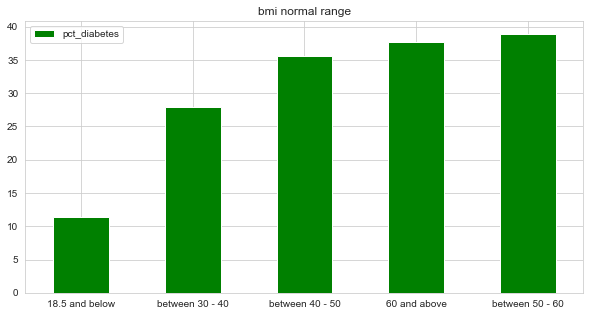

In [39]:
g.reset_index(inplace=True)
ax = g.plot.bar(x='bmi_noraml_range', y='pct_diabetes', figsize=(10,5), color='green', rot=0,
               title='bmi normal range', xlabel='')

## glucose

In [40]:
print(f'Number of null in glucose column: {sum(df_train["glucose_apache"].isnull())}')

Number of null in glucose column: 14696


In [41]:
df_dic[df_dic['Variable Name'].str.contains('glucose')]

,Category,Variable Name,Unit of Measure,Data Type,Description,Example,norma_val_low,norma_val_high,link
30,APACHE covariate,glucose_apache,mg/dL,numeric,The glucose concentration measured during the first 24 hours which results in the highest APACHE III score,5,0,140,https://www.google.com/search?q=glucose+mmol%2Fl+normal+range&oq=glucose+mm&aqs=chrome.0.69i59j69i57j0i512l7.3538j0j4&sourceid=chrome&ie=UTF-8
107,labs,d1_glucose_max,mg/dL,numeric,The highest glucose concentration of the patient in their serum or plasma during the first 24 hours of their unit stay,5,0,140,https://www.google.com/search?q=glucose+mmol%2Fl+normal+range&oq=glucose+mm&aqs=chrome.0.69i59j69i57j0i512l7.3538j0j4&sourceid=chrome&ie=UTF-8
108,labs,d1_glucose_min,mg/dL,numeric,The lowest glucose concentration of the patient in their serum or plasma during the first 24 hours of their unit stay,5,0,140,https://www.google.com/search?q=glucose+mmol%2Fl+normal+range&oq=glucose+mm&aqs=chrome.0.69i59j69i57j0i512l7.3538j0j4&sourceid=chrome&ie=UTF-8
137,labs,h1_glucose_max,mg/dL,numeric,The highest glucose concentration of the patient in their serum or plasma during the first hour of their unit stay,5,0,140,https://www.google.com/search?q=glucose+mmol%2Fl+normal+range&oq=glucose+mm&aqs=chrome.0.69i59j69i57j0i512l7.3538j0j4&sourceid=chrome&ie=UTF-8
138,labs,h1_glucose_min,mg/dL,numeric,The lowest glucose concentration of the patient in their serum or plasma during the first hour of their unit stay,5,0,140,https://www.google.com/search?q=glucose+mmol%2Fl+normal+range&oq=glucose+mm&aqs=chrome.0.69i59j69i57j0i512l7.3538j0j4&sourceid=chrome&ie=UTF-8


In [53]:
df_train[['glucose_apache', 'd1_glucose_max', 'd1_glucose_min']].describe().T

,count,mean,std,min,25%,50%,75%,max
glucose_apache,115461.0,160.141416,90.701327,39.0,97.0,133.0,195.0,598.7
d1_glucose_max,121914.0,174.149802,86.545466,73.0,117.0,150.0,200.0,611.0
d1_glucose_min,121914.0,114.440310,38.217682,33.0,91.0,108.0,131.0,288.0


In [54]:
def glucose_infl(val_lst, col_name, col):
    glucose_df[col_name] = None
    glucose_df.loc[glucose_df[col] <= val_lst[0], col_name] = f'{val_lst[0]} and below'
    for i in range(1, len(val_lst)-1):
        glucose_df.loc[(glucose_df[col] > val_lst[i]) & (glucose_df[col] <= val_lst[i+1]),col_name] = f'between {val_lst[i]} - {val_lst[i+1]}'
    glucose_df.loc[glucose_df[col] > val_lst[-1], col_name] = f'{val_lst[-1]} and above'

In [55]:
glucose_df = df_train[['glucose_apache', 'diabetes_mellitus']].copy()
# wierd phenomena append in 50
val_lst = [140, 160, 180, 200, 225, 250, 275, 300, 350, 400]
glucose_infl(val_lst, 'glucose_noraml_range', 'glucose_apache')
g = glucose_df.groupby(['glucose_noraml_range']).agg(pct_diabetes=pd.NamedAgg(column="diabetes_mellitus", aggfunc=lambda x: 100*(x.sum() / len(x))),
                                         num_of_patients=pd.NamedAgg(column="diabetes_mellitus", aggfunc=lambda x: len(x)))
g.sort_values(by='pct_diabetes', inplace=True)
g

,pct_diabetes,num_of_patients
glucose_noraml_range,,
140 and below,11.200752,60612
between 160 - 180,24.005891,10185
between 180 - 200,31.875632,7912
between 200 - 225,39.921523,6881
between 225 - 250,47.683706,5008
between 250 - 275,53.955037,3603
between 275 - 300,55.844619,2806
between 350 - 400,57.784431,2004
between 300 - 350,58.509761,3637


In [56]:
glucose_df = df_train[['d1_glucose_max','glucose_apache', 'd1_glucose_min', 'diabetes_mellitus']].copy()
glucose_df['apache_cal'] = 0.92*df_train['d1_glucose_max'] + 0.47*df_train['d1_glucose_min']
glucose_df = glucose_df[['apache_cal', 'diabetes_mellitus']].copy()
# wierd phenomena append in 50
val_lst = [140, 160, 180, 200, 225, 250, 275, 300, 350, 400]
glucose_infl(val_lst, 'glucose_noraml_range', 'apache_cal')
g2 = glucose_df.groupby(['glucose_noraml_range']).agg(pct_diabetes=pd.NamedAgg(column="diabetes_mellitus", aggfunc=lambda x: 100*(x.sum() / len(x))),
                                         num_of_patients=pd.NamedAgg(column="diabetes_mellitus", aggfunc=lambda x: len(x)))
g2.sort_values(by='pct_diabetes', inplace=True)
g2

,pct_diabetes,num_of_patients
glucose_noraml_range,,
140 and below,6.012747,17729
between 160 - 180,11.348771,16971
between 180 - 200,15.388548,15648
between 200 - 225,21.256859,15308
between 225 - 250,30.094285,10394
between 250 - 275,37.766033,7001
between 275 - 300,46.945010,4910
between 300 - 350,53.786964,6628
between 350 - 400,58.375378,3964


In [57]:
pd.concat([g, g2], axis=1)

,pct_diabetes,num_of_patients,pct_diabetes,num_of_patients
glucose_noraml_range,,,,
140 and below,11.200752,60612,6.012747,17729
between 160 - 180,24.005891,10185,11.348771,16971
between 180 - 200,31.875632,7912,15.388548,15648
between 200 - 225,39.921523,6881,21.256859,15308
between 225 - 250,47.683706,5008,30.094285,10394
between 250 - 275,53.955037,3603,37.766033,7001
between 275 - 300,55.844619,2806,46.945010,4910
between 350 - 400,57.784431,2004,58.375378,3964
between 300 - 350,58.509761,3637,53.786964,6628


In [58]:
glucose_df = df_train[['d1_glucose_max', 'diabetes_mellitus']].copy()
# wierd phenomena append in 50
val_lst = [140, 160, 180, 200, 225, 250, 275, 300, 350, 400]
glucose_infl(val_lst, 'glucose_noraml_range', 'd1_glucose_max')
g1 = glucose_df.groupby(['glucose_noraml_range']).agg(pct_diabetes=pd.NamedAgg(column="diabetes_mellitus", aggfunc=lambda x: 100*(x.sum() / len(x))),
                                         num_of_patients=pd.NamedAgg(column="diabetes_mellitus", aggfunc=lambda x: len(x)))
g1.sort_values(by='pct_diabetes', inplace=True)
g1

,pct_diabetes,num_of_patients
glucose_noraml_range,,
140 and below,7.483070,53160
between 160 - 180,22.421735,12809
between 180 - 200,30.440921,9208
between 200 - 225,38.305780,7803
between 225 - 250,46.971059,5563
between 250 - 275,53.335005,3988
between 275 - 300,55.119896,3086
between 300 - 350,58.281753,4039
between 350 - 400,59.655914,2325


## gender

In [59]:
print(f'Number of null in gender column: {sum(df_train["gender"].isnull())}')
print(f'Number of null in gender column: {sum(df_test["gender"].isnull())}')

Number of null in gender column: 66
Number of null in gender column: 5


In [60]:
gender_df = df_train[['gender', 'diabetes_mellitus']].copy()

g = gender_df.groupby(['gender']).agg(pct_diabetes=pd.NamedAgg(column="diabetes_mellitus", aggfunc=lambda x: 100*(x.sum() / len(x))),
                                         num_of_patients=pd.NamedAgg(column="diabetes_mellitus", aggfunc=lambda x: len(x)))
g.sort_values(by='pct_diabetes', inplace=True)
g

,pct_diabetes,num_of_patients
gender,,
F,21.362026,59573
M,21.866757,70518


## hospital_id, icu_id

In [61]:
print(f'Number of hospitals: {len(df_train.hospital_id.value_counts(ascending=False))}')
print(f'Number of icu: {len(df_train.icu_id.value_counts(ascending=False))}')

Number of hospitals: 204
Number of icu: 328


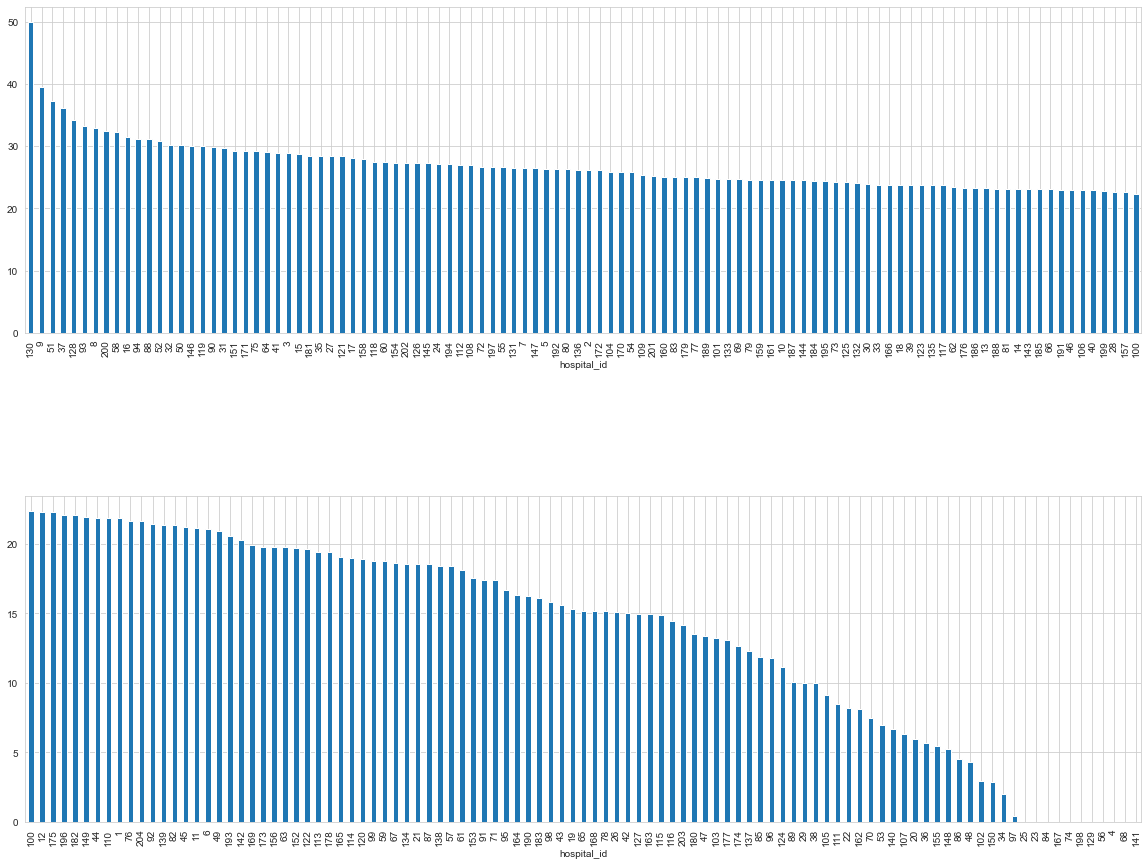

In [62]:
g = df_train.groupby(['hospital_id']).agg(pct_diabetes=pd.NamedAgg(column="diabetes_mellitus", aggfunc=lambda x: 100*(x.sum() / len(x))),
                                         pateiants_per_hospital=pd.NamedAgg(column="diabetes_mellitus", aggfunc=lambda x: len(x)))
g.sort_values(by='pct_diabetes',ascending=False, inplace=True)
fig, axs = plt.subplots(2)
g.loc[:100,'pct_diabetes'].plot(kind='bar', ax=axs[0], figsize=(20,15))
g.loc[100:,'pct_diabetes'].plot(kind='bar', ax=axs[1], figsize=(20,15))
plt.subplots_adjust(hspace=0.5)

In [63]:
g

,pct_diabetes,pateiants_per_hospital
hospital_id,,
130,50.000000,2
9,39.534884,43
51,37.272727,110
37,36.239782,734
128,34.207969,1029
93,33.333333,6
8,32.989691,388
200,32.425068,367
58,32.366071,1344


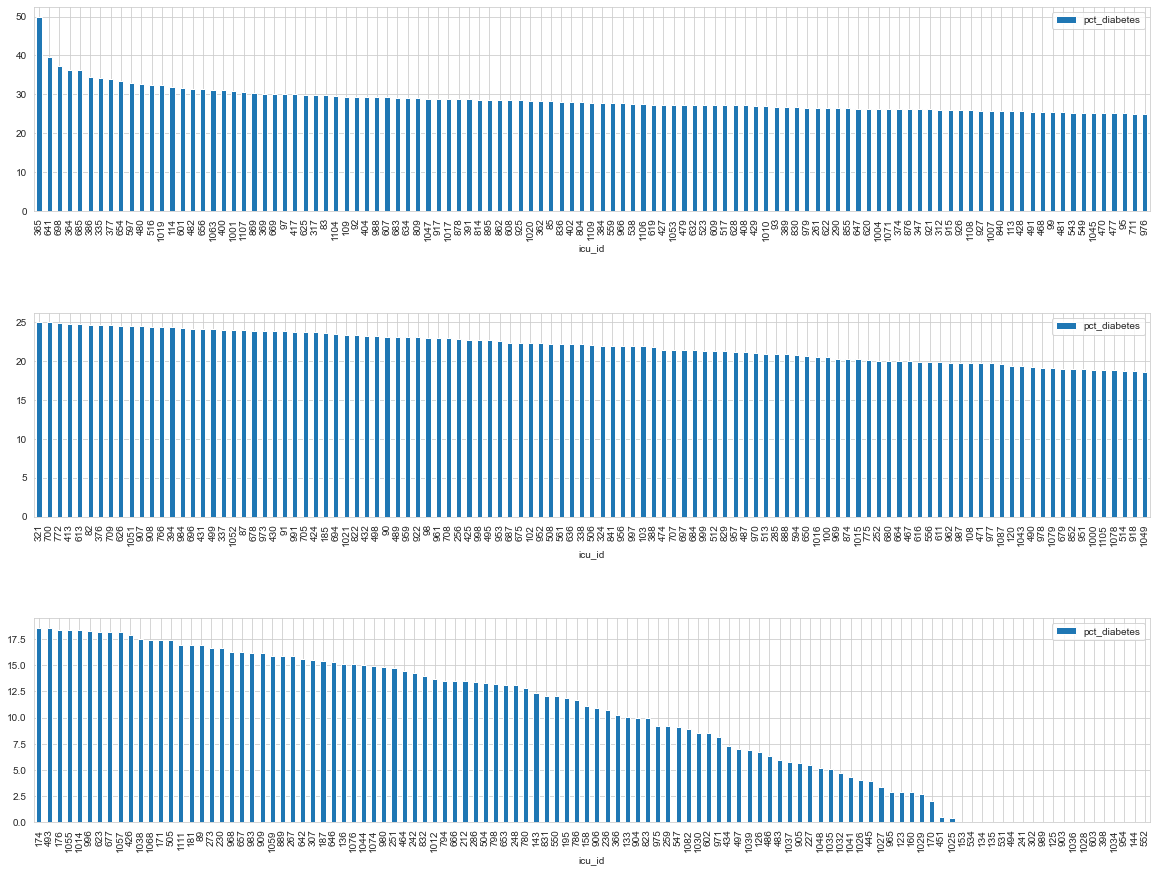

In [64]:
g = df_train.groupby(['icu_id']).agg(pct_diabetes=pd.NamedAgg(column="diabetes_mellitus", aggfunc=lambda x: 100*(x.sum() / len(x))),
                                         pateiants_in_icu=pd.NamedAgg(column="diabetes_mellitus", aggfunc=lambda x: len(x)))
g.sort_values(by='pct_diabetes',ascending=False, inplace=True)
g.reset_index(inplace=True)
sl = int(len(g)/3)
fig, axs = plt.subplots(3)
g[:sl].plot.bar(x='icu_id', y='pct_diabetes', ax=axs[0], figsize=(20,15))
g[sl:2*sl].plot.bar(x='icu_id', y='pct_diabetes', ax=axs[1], figsize=(20,15))
g[2*sl:].plot.bar(x='icu_id', y='pct_diabetes', ax=axs[2], figsize=(20,15))
plt.subplots_adjust(hspace=0.5)

In [65]:
g

,icu_id,pct_diabetes,pateiants_in_icu
0,365,50.000000,2
1,641,39.534884,43
2,698,37.272727,110
3,364,36.363636,77
4,685,36.239782,734
5,386,34.400000,125
6,335,34.210526,304
7,377,33.843212,523
8,654,33.333333,6
9,597,32.989691,388


In [68]:
def df_print(col_name):
    g = df_train.groupby([col_name]).agg(pct_diabetes=pd.NamedAgg(column="diabetes_mellitus",aggfunc=lambda x: x.sum()/len(x)),
                                        num_of_patients=pd.NamedAgg(column="diabetes_mellitus", aggfunc=lambda x: len(x)))
    return g.sort_values(by='pct_diabetes', ascending=False)

In [72]:
print(f'icu_admit_source: \n{df_dic[df_dic["Variable Name"]=="icu_admit_source"]["Description"].values[0]}')
df_print('icu_admit_source')

icu_admit_source: 
The location of the patient prior to being admitted to the unit


,pct_diabetes,num_of_patients
icu_admit_source,,
Floor,0.234913,21459
Accident & Emergency,0.217071,76846
Operating Room / Recovery,0.204986,27436
Other ICU,0.189607,712
Other Hospital,0.183891,3464


In [73]:
print(f'icu_stay_type: \n{df_dic[df_dic["Variable Name"]=="icu_stay_type"]["Description"].values[0]}')
df_print('icu_stay_type')

icu_stay_type: 
nan


,pct_diabetes,num_of_patients
icu_stay_type,,
readmit,0.281301,615
admit,0.216328,124741
transfer,0.206832,4801


In [74]:
print(f'icu_type: \n{df_dic[df_dic["Variable Name"]=="icu_type"]["Description"].values[0]}')
df_print('icu_type')

icu_type: 
A classification which indicates the type of care the unit is capable of providing


,pct_diabetes,num_of_patients
icu_type,,
CSICU,0.277856,4981
CTICU,0.238999,4477
MICU,0.238487,10944
CCU-CTICU,0.228431,11220
Cardiac ICU,0.218463,8276
Med-Surg ICU,0.217132,71468
SICU,0.184185,8258
Neuro ICU,0.159214,10533


## APACHE comorbidity

In [75]:
APACHE_comorbidity_lst = []
APACHE_comorbidity_pct_lst = []
APACHE_comorbidity_num_lst = []
APACHE_comorbidity_des = []
for i in range(len(df_dic)):
    if df_dic['Category'][i] == 'APACHE comorbidity':
            apa_com = df_dic['Variable Name'][i]
            num_op_patients = len(df_train[df_train[apa_com]==1])
            pct_apa_com = round(100*df_train[df_train[apa_com]==1]['diabetes_mellitus'].sum()/num_op_patients, 2)  
            APACHE_comorbidity_lst.append(apa_com)
            APACHE_comorbidity_pct_lst.append(pct_apa_com)
            APACHE_comorbidity_num_lst.append(num_op_patients)
            APACHE_comorbidity_des.append(df_dic['Description'][i])

APACHE_com_dic = {'APACHE_comorbidity': APACHE_comorbidity_lst,
                  'APACHE_description': APACHE_comorbidity_des,
                  'diabetes_pct': APACHE_comorbidity_pct_lst,
                  'num_of_patients': APACHE_comorbidity_num_lst}
g = pd.DataFrame(data=APACHE_com_dic)
g.sort_values(by='diabetes_pct', ascending=False)

,APACHE_comorbidity,APACHE_description,diabetes_pct,num_of_patients
1,cirrhosis,"Whether the patient has a history of heavy alcohol use with portal hypertension and varices, other causes of cirrhosis with evidence of portal hypertension and varices, or biopsy proven cirrhosis. This comorbidity does not apply to patients with a functioning liver transplant.",26.52,2093
2,hepatic_failure,"Whether the patient has cirrhosis and additional complications including jaundice and ascites, upper GI bleeding, hepatic encephalopathy, or coma.",24.97,1770
4,leukemia,"Whether the patient has been diagnosed with acute or chronic myelogenous leukemia, acute or chronic lymphocytic leukemia, or multiple myeloma.",23.34,951
5,lymphoma,Whether the patient has been diagnosed with non-Hodgkin lymphoma.,21.47,545
3,immunosuppression,"Whether the patient has their immune system suppressed within six months prior to ICU admission for any of the following reasons; radiation therapy, chemotherapy, use of non-cytotoxic immunosuppressive drugs, high dose steroids (at least 0.3 mg/kg/day of methylprednisolone or equivalent for at least 6 months).",20.86,3341
6,solid_tumor_with_metastasis,Whether the patient has been diagnosed with any solid tumor carcinoma (including malignant melanoma) which has evidence of metastasis.,17.91,2714
0,aids,Whether the patient has a definitive diagnosis of acquired immune deficiency syndrome (AIDS) (not HIV positive alone),8.21,134


## gcs

In [81]:
gcs_lst = ['gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache',
       'gcs_verbal_apache']
df_train[gcs_lst].isnull().sum()

gcs_eyes_apache      2190
gcs_motor_apache     2190
gcs_unable_apache     709
gcs_verbal_apache    2190
dtype: int64

In [82]:
gcs_mask_df = df_train[(df_train['gcs_eyes_apache'].isnull()) & (df_train['gcs_motor_apache'].isnull()) & df_train['gcs_verbal_apache'].isnull()].copy()
100 * len(gcs_mask_df[gcs_mask_df['gcs_unable_apache']==1]) / len(gcs_mask_df)
print(f'The number of Na in gcs_unable_apache column when the other  gcs columns are all togheter Na:\
 {len(gcs_mask_df[gcs_mask_df["gcs_unable_apache"].isnull()])}') 

The number of Na in gcs_unable_apache column when the other  gcs columns are all togheter Na: 709


In [83]:
#gcs_mask_df[gcs_mask_df["gcs_unable_apache"]==1]['apache_3j_diagnosis'].value_counts()

<AxesSubplot:>

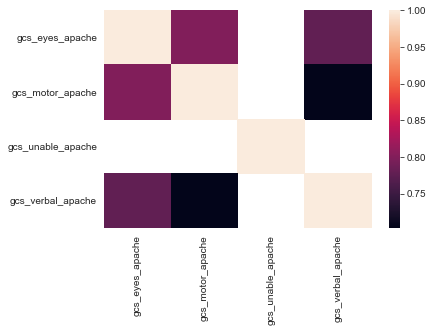

In [84]:
# so the connection of **gcs_unable_apache** column to other **gcs** test
# df_dic[df_dic['Variable Name'].str.contains('gcs')]
gcs_lst = ['gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache']
sns.heatmap(df_train[gcs_lst].corr())

## columns relations

* removing: ['encounter_id', 'hospital_id', 'icu_id']
* the meaning is not clear: ['icu_stay_type', 'apache_post_operative']
* duplication columns to be check by correlation:

['icu_admit_type' - (not exist), 'icu_type'],

['d1_diasbp_invasive_max' - 'd1_diasbp_max' - 'd1_diasbp_noninvasive_max' - 'd1_mbp_invasive_max' - 'd1_mbp_max' - 'd1_mbp_noninvasive_max' - 'h1_diasbp_invasive_max', 'h1_diasbp_max' - 'h1_diasbp_noninvasive_max' - 'h1_mbp_invasive_max' - 'h1_mbp_max' - 'h1_mbp_noninvasive_max'],

['d1_heartrate_max'-'d1_heartrate_min'-'heart_rate_apache', 'h1_heartrate_max', 'h1_heartrate_min'],

['d1_diasbp_invasive_min' - 'd1_diasbp_min' - 'd1_diasbp_noninvasive_min' - 'd1_mbp_invasive_min', 'd1_mbp_min' - 'd1_mbp_noninvasive_min'- 'h1_mbp_invasive_min' - 'h1_mbp_min' - 'h1_mbp_noninvasive_min' - 'h1_diasbp_noninvasive_min' - 'h1_diasbp_min' - 'h1_diasbp_invasive_min'],

['d1_resprate_max' - 'd1_resprate_min' - 'resprate_apache'- 'h1_resprate_max' - 'h1_resprate_min' - 'h1_sysbp_noninvasive_min'],

['d1_sysbp_invasive_max' - 'd1_sysbp_max' - 'd1_sysbp_max' - 'h1_sysbp_invasive_max' - 'h1_sysbp_max' - 'h1_sysbp_noninvasive_max'], 

['d1_sysbp_invasive_min' - 'd1_sysbp_min' - 'd1_sysbp_noninvasive_min' - 'h1_sysbp_invasive_min' - 'h1_sysbp_min']
['temp_apache' - 'd1_temp_max'- 'd1_temp_min' - 'h1_temp_max' - 'h1_temp_min'], ['h1_spo2_max'- 'd1_spo2_max'], 

['h1_spo2_min'- 'd1_spo2_min'], 
['h1_spo2_max'- 'd1_spo2_max'],

['d1_albumin_max' - 'd1_albumin_min' - 'h1_albumin_max', 'h1_albumin_min' - 'albumin_apache']
['d1_bilirubin_max' - 'd1_bilirubin_min' - 'h1_bilirubin_max', 'h1_bilirubin_min' - 'bilirubin_apache']
['d1_bun_max' - 'd1_bun_min' - 'h1_bun_max', 'h1_bun_min' - 'bun_apache']
['d1_creatinine_max' - 'd1_creatinine_min' - 'h1_creatinine_max', 'h1_creatinine_min' - 'creatinine_apache']
['d1_glucose_max' - 'd1_glucose_min' - 'h1_glucose_max', 'h1_glucose_min' - 'glucose_apache']
['d1_calcium_max' - 'd1_calcium_min' - 'h1_calcium_max', 'h1_calcium_min']
['d1_bicarbonate_max' - 'd1_bicarbonate_min' - 'h1_bicarbonate_max', 'h1_bicarbonate_min']
['d1_hemaglobin_max' - 'd1_hemaglobin_min' - 'h1_hemaglobin_max', 'h1_hemaglobin_min']
['d1_hematocrit_max' - 'd1_hematocrit_min' - 'h1_hematocrit_max', 'h1_hematocrit_min' - 'hematocrit_apache']
['d1_inr_max' - 'd1_inr_min' - 'h1_inr_max', 'h1_inr_min']
['d1_lactate_max' - 'd1_lactate_min' - 'h1_lactate_max', 'h1_lactate_min']
['d1_potassium_max' - 'd1_potassium_min' - 'h1_potassium_max', 'h1_potassium_min']
['d1_sodium_max' - 'd1_sodium_min' - 'h1_sodium_max', 'h1_sodium_min' - 'sodium_apache']
['d1_wbc_max' - 'd1_wbc_min' - 'h1_wbc_max', 'h1_wbc_min' - 'wbc_apache']
['d1_pco2_max' - 'd1_pco2_min' - 'h1_pco2_max', 'h1_pco2_min' - 'paco2_for_ph_apache']
['d1_arterial_ph_max' - 'd1_arterial_ph_min' - 'h1_arterial_ph_max', 'h1_arterial_ph_min' - 'ph_apache']
['d1_arterial_po2_max' - 'd1_arterial_po2_min' - 'h1_arterial_po2_max', 'h1_arterial_po2_min']



* impotrant colums: ['weight', 'height', 'bmi', 'glucose', 'age', 'ethnicity']
* categorial columns despite they are integer: ['apache_2_diagnosis', 'apache_3j_diagnosis', 'gcs_eyes_apache',
'gcs_motor_apache', 'gcs_verbal_apache']
* leakage to be checked: ['apache_2_diagnosis', 'apache_3j_diagnosis']
['d1_pao2fio2ratio_max', 'd1_pao2fio2ratio_min', 'h1_pao2fio2ratio_max', 'h1_pao2fio2ratio_min', 'pao2_apache', 'fio2_apache']


columns category:
* 'labs' - blood test
* 'vitals' - importante measures in icu (heart beat, blood pressure etc..)
* 'APACHE covariate' - define APACHE state (maybe a leakage)
* 'labs blood gas' - blood gas tests
* 'demographic' - general details
* 'APACHE comorbidity' - define extra illness
* 'identifier' - id (not relevant)

### meaning of 'icu_stay_type', 'apache_post_operative' columns

In [85]:
# readmit - patients that admit more than one time
# admit - patients that admit only one time
# transfer - patients that moved from one icu to another
df_print('icu_stay_type')

,pct_diabetes,num_of_patients
icu_stay_type,,
readmit,0.281301,615
admit,0.216328,124741
transfer,0.206832,4801


In [86]:
# status of apache that taken, 1 after a surgery, 0 before a surgary
print(df_dic[df_dic['Variable Name']=='apache_post_operative']['Description'].values[0])
df_print('apache_post_operative')

The APACHE operative status; 1 for post-operative, 0 for non-operative


,pct_diabetes,num_of_patients
apache_post_operative,,
0,0.218760,103200
1,0.206811,26957
